# Camphor: SI Figure 9

In [1]:
# Some magic commands
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pathlib import Path
import nmrespy as ne

root = Path("../..")
molecule = "camphor"
data_path = root / "data" / molecule / "1"
output_dir = root / "code" / molecule / "output"

output_dir.mkdir(exist_ok=True, parents=True)

In [3]:
redo_estimation = False

estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file() and not redo_estimation:
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_path)
    estimator.phase_data(p0=5.238, p1=-6.262)
    estimator.baseline_correction()

In [4]:
import numpy as np

np.random.seed(0)

try:
    estimator.get_results()
except ValueError:
    regions = [
        (2.55, 2.475),
        (2.35, 2.23),
        (2.09, 2.025),
        (1.95, 1.75),
        (1.7, 1.61),
        (1.375, 1.215),
    ]
    
    estimate_kwargs = dict(
        noise_region=(5.25, 5.21),
        region_unit="ppm",
        max_iterations=100,
        nlp_trim=2048,
        check_neg_amps_every=25,
    )
    for region in regions:
        estimator.estimate(region=region, **estimate_kwargs)
        estimator.to_pickle(estimator_path, force_overwrite=True)

┌────────────────────────────────────────┐
│ESTIMATING REGION: 2.55 - 2.475 ppm (F2)│
└────────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 6
--> Pencil parameters: 64, 34
--> Enhanced Block Hankel matrix constructed:
	Size: 2176 x 2275
	Memory: 75.5371MiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 2 secs, 545 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.410373     │ 68.3457      │ 1

## Plotting the Result

**N.B.** the threshold for determining multiplets has been increased to ensure it performs effectively. This is often a necessity.
It has been set to $2 f_{\text{sw}}^{(2)} / N^{(2)}$, where $f_{\text{sw}}^{(2)}$, i.e. double the spectral resoultion in the direct dimension.

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["xtick.labelsize"] = 7
colors = ["#1063E0", "#EB9310", "#2BB539", "#D4200C", "#808080"]

mp_thold = 2.0 * estimator.sw("hz")[1] / estimator.default_pts[1]

def plot_result(estimator, mp_indices):
    mp_cols = [colors[i] for i in mp_indices]
        
    fig, axs = estimator.plot_result(
        xaxis_ticks=[
            (0, [2.54, 2.52, 2.5, 2.48]),
            (1, [2.34, 2.32, 2.3, 2.28, 2.26, 2.24]),
            (2, [2.08, 2.06, 2.04]),
            (3, [1.94, 1.92, 1.9, 1.88, 1.86, 1.84, 1.82, 1.8, 1.78, 1.76]),
            (4, [1.68, 1.66, 1.64, 1.62]),
            (5, [1.36 - 0.02 * i for i in range(7)]),
        ],
        multiplet_colors=mp_cols,
        region_unit="ppm",
        multiplet_thold=mp_thold,
        multiplet_lw=0.8,
        marker_size=15.0,
        figsize=(12.0, 4.0),
        axes_left=0.05,
        axes_right=0.95,
        axes_bottom=0.1,
        axes_top=0.98,
        contour_base=1.0e4,
        contour_factor=1.5,
        contour_nlevels=10,
        contour_color="#b0b0b0",
    )
    
    for line in axs[1, 0].get_lines():
        if line.get_color() != "k":
            line.remove()
            
    return fig, axs

The figure below has been generated with some modifications:

1. The signals related to the 1:2:3:2:1 heteronuclear multiplet asociatated with DMSO-d6 are given the same colour (2.52-2.5 ppm). The diagonal and vertical lines linked to these signals are also removed.
2. The signals deemed to be linked to strong coupling artifacts are coloured grey.

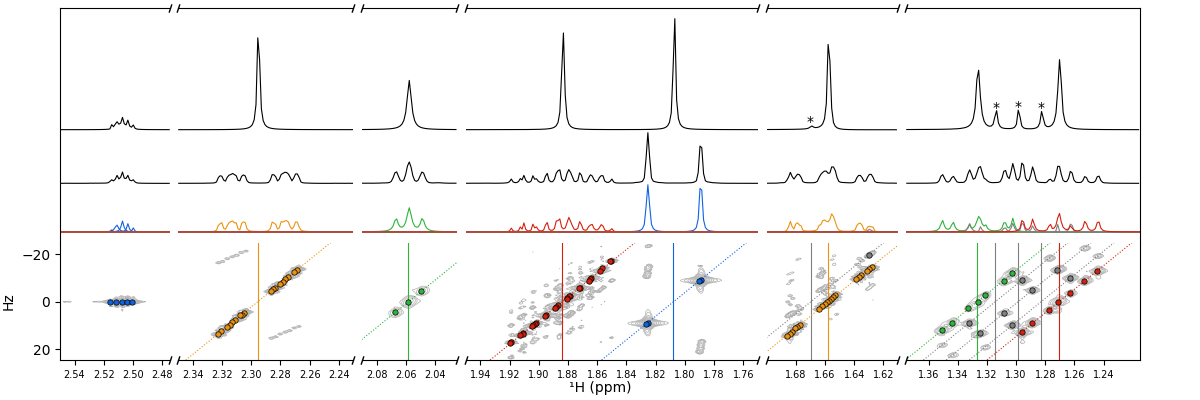

In [6]:
fig, axs = plot_result(estimator, [0, 0, 0, 0, 0, 1, 2, 3, 0, 4, 1, 2, 4, 4, 4, 3])

# Code to label stong coupling fetures in the homodecoupled spectrum.
axs[0, 4].text(1.67, 9.75e5, "*", ha="center")
axs[0, 5].text(1.314, 1.1e6, "*", ha="center")
axs[0, 5].text(1.299, 1.11e6, "*", ha="center")
axs[0, 5].text(1.283, 1.1e6, "*", ha="center");

## Strong Coupling Artifacts

Some strong coupling artifacts have been fit to the data, which have been coloured grey. Their influence in the homodecoupled spectrum are marked with asterisks.

Let's call `predict_multiplets`, making sure to specify the threshold described above, with `rm_spurious=True` to see if any can be removed.

In [8]:
estimator.predict_multiplets(thold=mp_thold, rm_spurious=True)

estimator_rmsp_path = output_dir / "estimator_rmsp.pkl"
if not estimator_rmsp_path.is_file():
    estimator.to_pickle(estimator_rmsp_path)

Saved file ../../code/camphor/output/estimator_rmsp.pkl.


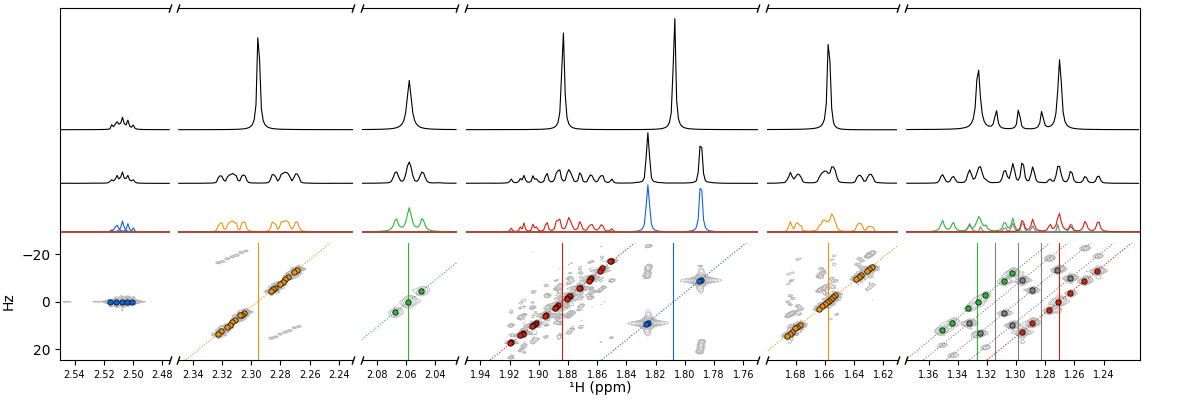

In [10]:
_, _ = plot_result(estimator, [0, 0, 0, 0, 0, 1, 2, 3, 0, 1, 2, 4, 4, 4, 3])

### Manually Removing Persistent Strong Coupling Artifacts

Only one signal was removed (at ~1.63 ppm). The others, in the 1.34-1.26 ppm region were not removed, since they do not violate the first-order signal criteria. NMR-EsPy does not have any automated means to remove these as distinguishing them from true first-order signals is not strightforward.

If the user is confident of the presence of strong coupling artifacts, they can be manually removed. First it is necessary to identify the indices associated with the signals. The region of interest has index `5` (i.e. it was the 6th region considered). Calling `predict_multiplets`, with `indices=[5]` will give us the information needed.

In [11]:
multiplets = estimator.predict_multiplets(indices=[5], thold=mp_thold)
sfo = estimator.sfo[1]
for freq, indices in multiplets.items():
    print("{:.3f} ppm : {}".format(freq / sfo, indices))

1.271 ppm : [0, 1, 3, 4, 6, 7, 10]
1.283 ppm : [2, 12]
1.299 ppm : [5, 8, 13, 16]
1.314 ppm : [9, 18]
1.327 ppm : [11, 14, 15, 17, 19, 20, 21]


The signals of interest come from the multiplets centered about 1.283, 1.299, and 1.314 ppm. The indices of interest can be extracted as follows:

In [12]:
mp_indices = list(multiplets.values())
print("All indices: {}".format(mp_indices))
sc_indices = mp_indices[1:4]
print("Strong coupling indices: {}".format(sc_indices))
# merge the lists together
sc_indices = [item for sublist in sc_indices for item in sublist]
print("Merged: {}".format(sc_indices))

All indices: [[0, 1, 3, 4, 6, 7, 10], [2, 12], [5, 8, 13, 16], [9, 18], [11, 14, 15, 17, 19, 20, 21]]
Strong coupling indices: [[2, 12], [5, 8, 13, 16], [9, 18]]
Merged: [2, 12, 5, 8, 13, 16, 9, 18]


The signals can now be removed using `edit_result()`. This method should be used sparingly and only when the user is confident that the estimation is flawed in some way. Generally, the optimization algorithm should be performed again after the edit to ensure good agreement between the model signals and the data. However, in this case, it is not necessary, as we simply want to remove certain signals, while leving the rest unaffected. This can be facilited by passing `max_iterations=0`:

In [13]:
estimator.edit_result(index=5, rm_oscs=sc_indices, max_iterations=0)

estimator_final_path = output_dir / "estimator_final.pkl"
if not estimator_final_path.is_file():
    estimator.to_pickle(estimator_final_path)

Saved file ../../code/camphor/output/estimator_final.pkl.


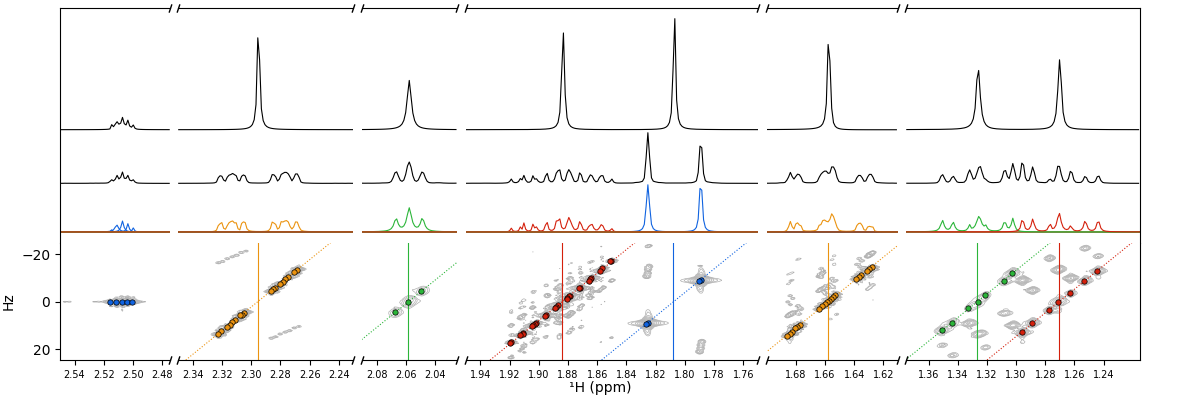

In [15]:
_, _ = plot_result(estimator, [0, 0, 0, 0, 0, 1, 2, 3, 0, 1, 2, 3])